## Conditional entropies evaluation
#### Test conditions: 
    a = 0.5
    b = 1/16.0
    A = 2.5
    omega = 2.0
    gamma = 0.1
    period = 2*np.pi/(1.0*omega)
    h = period/32 # time step
    
    new_data = position[::23]

In [2]:
import sys
sys.path.insert(0, '../../dcgram_v2')
import save_plot as sp
import numpy as np
sys.path.insert(0, '../../dcgram_v2/tests')
from pibic import *
import yaml
import matplotlib.pyplot as plt
import itertools

path = '../..'

In [2]:
# sp.save_plot(parameter='cond_entropies', name='duffing_equation', drange = range(2,6), krange = [3, 5, 7])

## Kolmogorov-Smirnov Tests

In [17]:
def kolmogorov_test(beta = 0.1, D = 2, K = 3, \
                    subseq_len = 1000, subseq_rep = 1000, dataset = 'duffing_equation', L = 1391305):
    
    leg = '{:1.2f}'.format(beta).replace('.', '')
    with open(f'{path}/dcgram_files/{dataset}/original/original_len_{L}.yaml', 'r') as f:
        s = yaml.load(f)    
    with open(f'{path}/dcgram_files/{dataset}/results/machines/dcgram/dcgram_D{D}_K{K}.yaml', 'r') as f:
        m_test = yaml.load(f)    
#     with open(f'{path}/dcgram_files/{dataset}/results/machines/dmarkov/dmark_D{D}.yaml', 'r') as f:
#         m_test = yaml.load(f)
    with open(f'{path}/dcgram_files/{dataset}_{leg}/original/original_len_{L}.yaml', 'r') as f:
        s_test = yaml.load(f)
    
#     occup_vector = sa.iterate_machine(m_test, L)    # Simulates ocuppation vector
    occup_vector = eig.occup_vector(m_test)    # Calculate occupation vector from eigen vectors
    occup_vector_anomaly = sa.calc_occup_vector_dict(m_test, s_test, subseq_len)
    
    stat, p = ks_2samp(occup_vector, occup_vector_anomaly)
    return stat, p

def plot_graph(x=[], y=[], D=2, K=3, N=1000, ylabel='p-value', legend = 'legend', color = 'k'):
    plt.plot(x, y, color, label = legend)
    plt.title(f'D={D}, K={K}')
    plt.xlabel(r'$\beta$')
    plt.ylabel(ylabel)
    plt.yscale('log')
    plt.legend()
    plt.savefig(f'plots/{ylabel}_D{D}_K{K}_{N}.png')

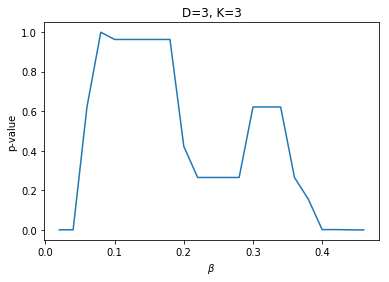

In [28]:
betas = np.arange(0.02, 0.48, 0.02)

p = []
stat = []

for D in [3]:
    K = 3
    
    for beta in betas:
        stval, pval = kolmogorov_test(beta = beta, D = D, K = K, subseq_len = 50000, subseq_rep = 1)
        p.append(pval)
        stat.append(stval)

    plot_graph(betas, p, D, K, ylabel='p-value')


In [29]:
# p_dmark_4 = p.copy()
# st_dmark_4 = stat.copy()
# p_dmark_3 = p.copy()
# st_dmark_3 = stat.copy()
# p_dcgram_4 = p.copy()
# st_dcgram_4 = stat.copy()
p_dcgram_3 = p.copy()
st_dcgram_3 = stat.copy()

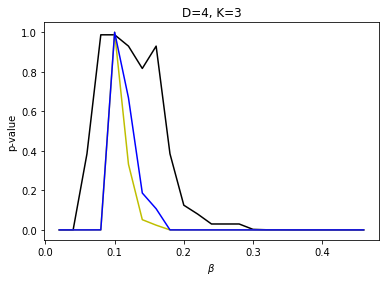

In [41]:
plot_graph(betas, p_dmark_3, D, K, ylabel='p-value', color= 'k')
# plot_graph(betas, p_dcgram_3, D, K, ylabel='p-value', color = 'r')
plot_graph(betas, p_dmark_4, D, K, ylabel='p-value', color= 'y')
plot_graph(betas, p_dcgram_4, D, K, ylabel='p-value', color = 'b')
# plot_graph(betas, stat, D, K, ylabel='p-value')

In [4]:
def evaluate_occup_div(D = 2, K = 3, N = 10000, L = 1391305, betas = []):
    dc_kl = []
    dm_kl = []

    for beta in betas:
        dataset = 'duffing_equation'
        leg = '{:1.2f}'.format(beta).replace('.', '')

        with open(f'{path}/dcgram_files/{dataset}/original/original_len_{L}.yaml', 'r') as f:
            s = yaml.load(f)    
        with open(f'{path}/dcgram_files/{dataset}/results/machines/dcgram/dcgram_D{D}_K{K}.yaml', 'r') as f:
            m_test = yaml.load(f)    
        with open(f'{path}/dcgram_files/{dataset}/results/machines/dmarkov/dmark_D{D}.yaml', 'r') as f:
            m = yaml.load(f)
        with open(f'{path}/dcgram_files/{dataset}_{leg}/original/original_len_{L}.yaml', 'r') as f:
            s_test = yaml.load(f)

        dc_occup_vector = eig.occup_vector(m_test)    # Calculate occupation vector from eigen vectors
        # occup_vector2 = sa.iterate_machine(m_test, L)    # Simulates ocuppation vector
        dc_occup_vector_anomaly = sa.calc_occup_vector_dict(m_test, s_test, N)
        dm_occup_vector = eig.occup_vector(m)    # Calculate occupation vector from eigen vectors
        dm_occup_vector_anomaly = sa.calc_occup_vector_dict(m, s_test, N)

        dc_kl.append(sa.calc_kldivergence_vector(dc_occup_vector, dc_occup_vector_anomaly))
        dm_kl.append(sa.calc_kldivergence_vector(dm_occup_vector, dm_occup_vector_anomaly))
        
    with open(f'kl_results/kl_dcgram_D{D}_K{K}_N{N}', 'w') as f:
        yaml.dump({'betas': betas, 'kl': dc_kl}, f)
    with open(f'kl_results/kl_dmark_D{D}_N{N}', 'w') as f:
        yaml.dump({'betas': betas, 'kl': dm_kl}, f)

In [ ]:
D = [1,2,3,4]
K = [3]
N = [1000, 5000, 10000, 100000]
b = np.arange(0.01, 0.48, 0.01)

possibilities = list(itertools.product(D, K, N))

for (D, K, N) in possibilities:
    evaluate_occup_div(D = D, K = K, N = N, betas = b)

In [21]:
def plot_kldiv(D = 2, K = 3, N = 10000):
    with open(f'kl_results/kl_dcgram_D{D}_K{K}_N{N}', 'r') as f:
        result = yaml.load(f)
        dc = result['kl']
    with open(f'kl_results/kl_dmark_D{D}_N{N}', 'r') as f:
        result = yaml.load(f)
        dm = result['kl']
        betas = result['betas']

    plot_graph(betas, dc, D, K, N = N, ylabel='kl_div', legend = 'DCGraM', color= 'y')
    plot_graph(betas, dm, D, K, N = N, ylabel='kl_div', legend = 'D-Markov', color = 'b')

In [22]:
D = [1,2,3,4]
K = [3]
N = [1000, 5000, 10000, 100000]
b = np.arange(0.01, 0.48, 0.01)

possibilities = list(itertools.product(D, K, N))

for (D, K, N) in possibilities:
    print((D,K,N))
    plot_kldiv(D, K, N)
    plt.clf()

(1, 3, 1000)
(1, 3, 5000)
(1, 3, 10000)
(1, 3, 100000)
(2, 3, 1000)
(2, 3, 5000)
(2, 3, 10000)
(2, 3, 100000)
(3, 3, 1000)
(3, 3, 5000)
(3, 3, 10000)
(3, 3, 100000)
(4, 3, 1000)
(4, 3, 5000)
(4, 3, 10000)
(4, 3, 100000)


<Figure size 432x288 with 0 Axes>